
Logistic Regression baseline
average_precision: 0.39
roc_auc: 0.8821
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      2415
           1       0.14      0.81      0.24        85

    accuracy                           0.83      2500
   macro avg       0.57      0.82      0.57      2500
weighted avg       0.96      0.83      0.88      2500

[[1995  420]
 [  16   69]]

Random Forest
average_precision: 0.8188
roc_auc: 0.9692
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2415
           1       0.91      0.61      0.73        85

    accuracy                           0.98      2500
   macro avg       0.95      0.80      0.86      2500
weighted avg       0.98      0.98      0.98      2500

[[2410    5]
 [  33   52]]


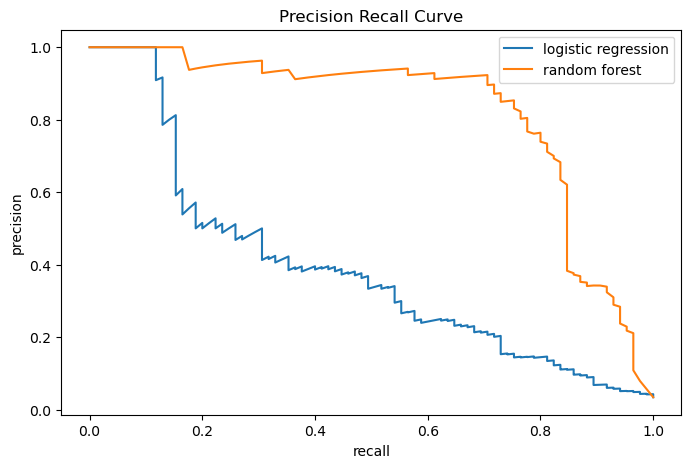

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
    roc_auc_score
)

# Load and clean
df = pd.read_csv("../data/raw/ai4i2020.csv")

df.columns = (
    df.columns
    .str.lower()
    .str.replace(" ", "_")
    .str.replace("[", "", regex=False)
    .str.replace("]", "", regex=False)
)

# Feature engineering
df["temp_diff"] = df["process_temperature_k"] - df["air_temperature_k"]

# Define target and remove leakage columns
target = "machine_failure"
failure_type_cols = ["twf", "hdf", "pwf", "osf", "rnf"]
id_cols = ["udi", "product_id"]

X = df.drop(columns=[target] + failure_type_cols + id_cols)
y = df[target]

categorical_features = ["type"]
numeric_features = [c for c in X.columns if c not in categorical_features]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

# Preprocess
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features),
    ]
)

# Models
logreg = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
    ]
)

rf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestClassifier(
            n_estimators=400,
            random_state=42,
            class_weight="balanced_subsample",
            n_jobs=-1
        ))
    ]
)

def evaluate_model(name, pipeline):
    pipeline.fit(X_train, y_train)

    proba = pipeline.predict_proba(X_test)[:, 1]
    pred = (proba >= 0.5).astype(int)

    ap = average_precision_score(y_test, proba)
    roc = roc_auc_score(y_test, proba)

    print("\n" + "="*60)
    print(name)
    print("average_precision:", round(ap, 4))
    print("roc_auc:", round(roc, 4))
    print(classification_report(y_test, pred))
    print(confusion_matrix(y_test, pred))

    return proba

proba_logreg = evaluate_model("Logistic Regression baseline", logreg)
proba_rf = evaluate_model("Random Forest", rf)

# Precision recall curves
p_lr, r_lr, t_lr = precision_recall_curve(y_test, proba_logreg)
p_rf, r_rf, t_rf = precision_recall_curve(y_test, proba_rf)

plt.figure(figsize=(8, 5))
plt.plot(r_lr, p_lr, label="logistic regression")
plt.plot(r_rf, p_rf, label="random forest")
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("Precision Recall Curve")
plt.legend()
plt.show()


In [2]:
from sklearn.metrics import precision_score, recall_score

def report_at_recall(name, proba, recall_target=0.85):
    precision, recall, thresholds = precision_recall_curve(y_test, proba)

    # thresholds length is one less than precision and recall
    best_idx = None
    for i in range(len(thresholds)):
        if recall[i] >= recall_target:
            best_idx = i
            break

    if best_idx is None:
        print("\n" + name)
        print("No threshold reaches recall target:", recall_target)
        return

    thr = thresholds[best_idx]
    preds = (proba >= thr).astype(int)

    p = precision_score(y_test, preds, zero_division=0)
    r = recall_score(y_test, preds)
    cm = confusion_matrix(y_test, preds)

    print("\n" + "="*60)
    print(name)
    print("threshold:", round(float(thr), 4))
    print("precision:", round(float(p), 4))
    print("recall:", round(float(r), 4))
    print(cm)

report_at_recall("Logistic Regression tuned", proba_logreg, recall_target=0.85)
report_at_recall("Random Forest tuned", proba_rf, recall_target=0.85)


Logistic Regression tuned
threshold: 0.0011
precision: 0.034
recall: 1.0
[[   0 2415]
 [   0   85]]

Random Forest tuned
threshold: 0.0
precision: 0.034
recall: 1.0
[[   0 2415]
 [   0   85]]


Logistic regression provides a strong baseline and achieves high recall for failures when class weights are used, but it produces many false positives. A random forest improves ranking performance for rare failures, shown by higher average precision and a stronger precision recall curve. Instead of using the default 0.5 cutoff, the decision threshold can be tuned to prioritize recall, which is often preferable in preventive maintenance where missed failures are more costly than additional inspections. Naively selecting the first threshold that reaches a recall target can result in extreme operating points, so threshold selection should reflect realistic operational tradeoffs.

In [3]:
def best_threshold_for_min_recall(proba, recall_min=0.85):
    precision, recall, thresholds = precision_recall_curve(y_test, proba)

    # precision and recall have length thresholds+1
    best = None
    for i, thr in enumerate(np.append(thresholds, 1.0)):
        p = precision[i]
        r = recall[i]
        if r >= recall_min:
            if best is None or p > best["precision"]:
                best = {"threshold": float(thr), "precision": float(p), "recall": float(r)}
    return best

def report_threshold(name, proba, thr):
    preds = (proba >= thr).astype(int)
    print("\n" + "="*60)
    print(name)
    print("threshold:", round(float(thr), 4))
    print(classification_report(y_test, preds))
    print(confusion_matrix(y_test, preds))

best_lr = best_threshold_for_min_recall(proba_logreg, recall_min=0.85)
best_rf = best_threshold_for_min_recall(proba_rf, recall_min=0.85)

print("Best LR (min recall 0.85):", best_lr)
print("Best RF (min recall 0.85):", best_rf)

report_threshold("Logistic Regression tuned (min recall 0.85)", proba_logreg, best_lr["threshold"])
report_threshold("Random Forest tuned (min recall 0.85)", proba_rf, best_rf["threshold"])

Best LR (min recall 0.85): {'threshold': 0.38915187723281636, 'precision': 0.1111111111111111, 'recall': 0.8588235294117647}
Best RF (min recall 0.85): {'threshold': 0.0825, 'precision': 0.37628865979381443, 'recall': 0.8588235294117647}

Logistic Regression tuned (min recall 0.85)
threshold: 0.3892
              precision    recall  f1-score   support

           0       0.99      0.76      0.86      2415
           1       0.11      0.86      0.20        85

    accuracy                           0.76      2500
   macro avg       0.55      0.81      0.53      2500
weighted avg       0.96      0.76      0.84      2500

[[1831  584]
 [  12   73]]

Random Forest tuned (min recall 0.85)
threshold: 0.0825
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2415
           1       0.38      0.86      0.52        85

    accuracy                           0.95      2500
   macro avg       0.69      0.90      0.75      2500
weighted avg    

At a fixed recall target of approximately 0.86, the random forest significantly outperforms logistic regression by achieving substantially higher precision. This results in far fewer false positives while maintaining strong failure detection, making the random forest a more practical choice for real-world preventive maintenance scenarios. These results highlight the importance of both model selection and threshold tuning when working with rare but costly events.